In [1]:
import numpy as np
import scipy.integrate as integrate
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import emcee
import corner

%matplotlib inline

## Part (a) &mdash; Generate samples from power-law IMF

In [2]:
def power_law_samples(N, M_min, M_max, alpha):
    """Function that generates samples from a power law distribution.
    Parameters:
    N: number of samples to be generated
    M_min: lower bound
    M_max: upper bound
    alpha: power law index"""
    
    #use inverse tranform sampling
    u = np.random.uniform(0.0,1.0,size=N)
    c = (float(M_max)/M_min)**(-alpha+1) - 1
    Ms = M_min * (1 + c * u)**(1./(-alpha+1))    
    return Ms

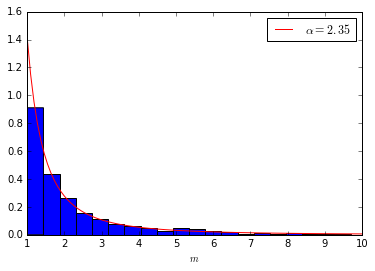

In [30]:
### let's generate some data
np.random.seed(11)
fake_sample_1 = power_law_samples(1000, 1, 10, 2.35)
plt.hist(fake_sample_1, bins=20, normed=True)
plt.plot(np.linspace(1,10,100),np.linspace(1,10,100)**(-2.35)/0.707653, c='r', \
         label=r'$\alpha=2.35$') # <- normalization spit out by Mathematica
plt.xlabel('$m$')
plt.legend()
plt.show()

## Part (b) &mdash; Parameter estimation on fake data from Part (a)

In [19]:
### probabilites here
def lnlike(alpha, M_min, M_max, M):
    norm = (1.-alpha)/(M_max**(1.-alpha) - M_min**(1.-alpha))
    return np.sum(np.log(norm) - alpha * np.log(M))

def lnprior(alpha):
    # let's assume flat priors
    if 1.0 < alpha < 5.0:
        return 0.0
    return -np.inf

def lnprob(alpha, M_min, M_max, M):
    lp = lnprior(alpha)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(alpha, M_min, M_max, M)

In [20]:
### now let's set up emcee
ndim, nwalkers = 1, 100
pos = [np.array([np.random.uniform(1.,3.)]) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[1, 10, fake_sample_1])
sampler.run_mcmc(pos, 1000);

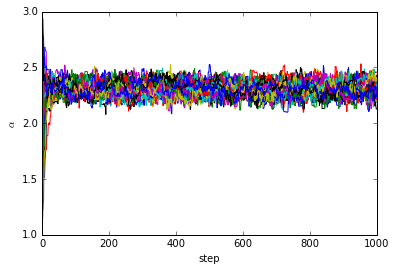

In [22]:
[plt.plot(sampler.chain[i,:,0]) for i in range(50)]
#[plt.plot(sampler.chain[i,:,0]) for i in range(sampler.chain.shape[0])]
plt.xlabel('step')
plt.ylabel(r'$\alpha$')
plt.show()

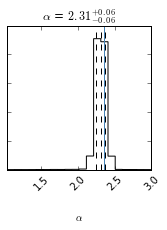

In [24]:
### corner plot
samples = sampler.chain[:,:, :].reshape((-1, ndim))
fig2 = corner.corner(samples, labels=[r"$\alpha$"], quantiles=[0.16, 0.5, 0.84], truths=[2.35], show_titles=True)
plt.show(fig2)

We generated data using $\alpha = 2.35$ and `emcee` recovers $\alpha = 2.31 \pm 0.06$. ok!

## Part (c) &mdash; Generate a new fake data set and do parameter estimation

In [25]:
### new fake data set
N = 1000
M_min = 3
M_max = 15
alpha = 2.35
fake_sample_2 = power_law_samples(N, M_min, M_max, alpha)

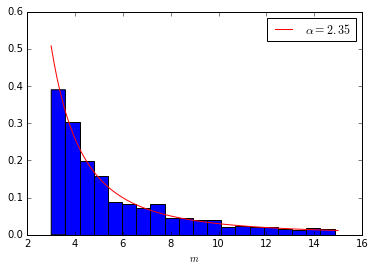

In [32]:
plt.hist(fake_sample_2, bins=20, normed=True)
plt.plot(np.linspace(3,15,100),np.linspace(3,15,100)**(-2.35)/0.148954, c='r', label=r'$\alpha=2.35$')
plt.xlabel('$m$')
plt.legend()
plt.show()

In [37]:
### probabilites here
def lnlike(theta, M_min, M):
    M_max, alpha = theta[0], theta[1]
    norm = (1.-alpha)/(M_max**(1.-alpha) - M_min**(1.-alpha))
    return np.sum(np.log(norm) - alpha * np.log(M))

def lnprior(theta, M):
    M_max, alpha = theta[0], theta[1]
    # let's assume flat priors
    if np.max(M) < M_max < 20. and 1.0 < alpha < 6.0:
        return 0.0
    return -np.inf

def lnprob(theta, M_min, M):
    lp = lnprior(theta, M)
    ll = lnlike(theta, M_min, M)
    if not np.isfinite(lp):
        return -np.inf
    return lp + ll

In [38]:
### now let's set up emcee
ndim, nwalkers = 2, 100
pos = [np.array([15, 2.5]) + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
#pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[3., fake_sample_2])
pos1, prob, state = sampler.run_mcmc(pos, 2000)
#sampler.reset()
#sampler.run_mcmc(pos1, 2000, rstate0=state);

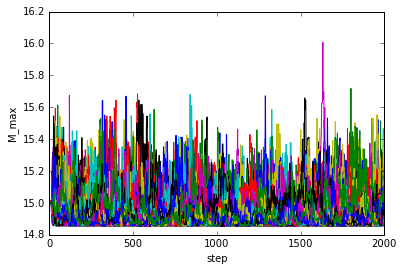

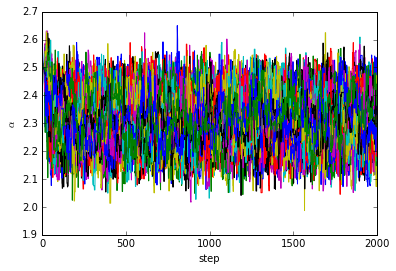

In [39]:
[plt.plot(sampler.chain[i,:,0]) for i in range(100)]
#[plt.plot(sampler.chain[i,:,0]) for i in range(sampler.chain.shape[0])]
plt.xlabel('step')
plt.ylabel(r'M_max')
plt.show()

[plt.plot(sampler.chain[i,:,1]) for i in range(100)]
#[plt.plot(sampler.chain[i,:,0]) for i in range(sampler.chain.shape[0])]
plt.xlabel('step')
plt.ylabel(r'$\alpha$')
plt.show()

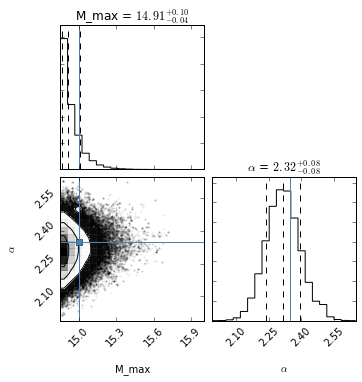

In [40]:
### corner plot
samples = sampler.chain[:,:, :].reshape((-1, ndim))
fig3 = corner.corner(samples, labels=["M_max", r"$\alpha$"], quantiles=[0.16, 0.5, 0.84], truths=[15, 2.35], \
                    show_titles=True)
plt.show(fig3)

I don't understand why the walkers just want to be stuck at the lowest value of $M_\text{max}$ set by the prior. :(

But we can recover $\alpha$ to within 1 $\sigma$: $2.32 \pm 0.08$.

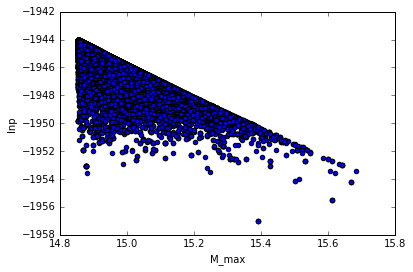

In [41]:
[plt.scatter(sampler.chain[i,:,0], sampler.lnprobability[i,:]) for i in range(50)]
plt.xlabel('M_max')
plt.ylabel('lnp');

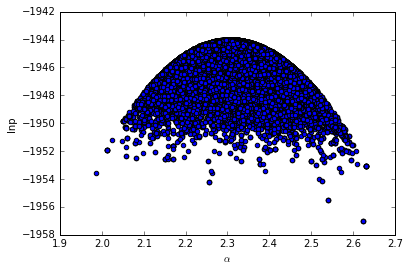

In [43]:
[plt.scatter(sampler.chain[i,:,1], sampler.lnprobability[i,:]) for i in range(50)]
plt.xlabel(r'$\alpha$')
plt.ylabel('lnp');

## Part (d)

We want to show how the precision to which we can recover $\alpha$ and $M_\text{max}$ depends on the number of sample points. To this end, we will generate a bunch of samples and use our inference code to see what results we get.

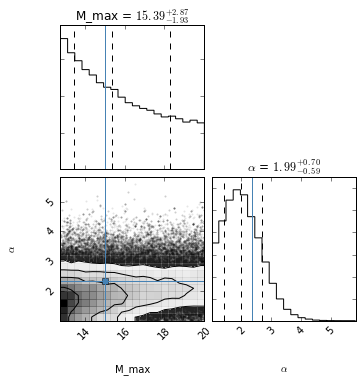

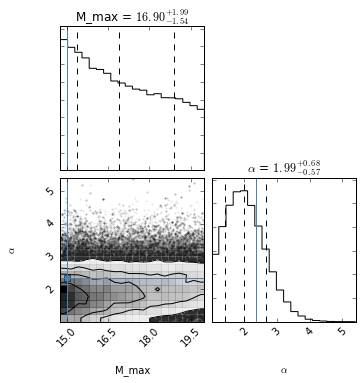

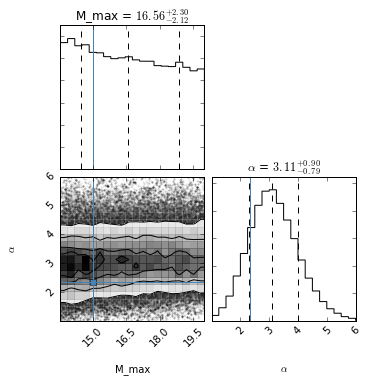

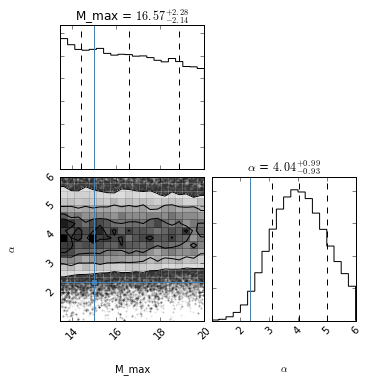

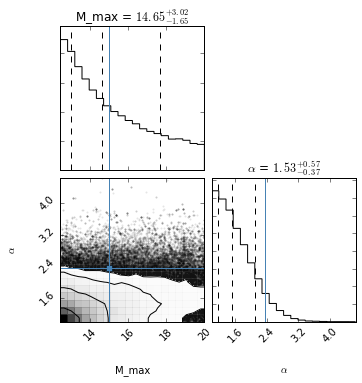

In [45]:
### try this a bunch of times for N=10
for i in range(5):
    N = 10
    M_min = 3
    M_max = 15
    alpha = 2.35
    sample = power_law_samples(N, M_min, M_max, alpha)
    
    ### now let's set up emcee
    ndim, nwalkers = 2, 100
    pos = [np.array([15, 2.5]) + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[3., sample])
    pos1, prob, state = sampler.run_mcmc(pos, 200)
    sampler.reset()
    sampler.run_mcmc(pos1, 2000, rstate0=state);
    
    samples = sampler.chain[:,:, :].reshape((-1, ndim))
    fig4 = corner.corner(samples, labels=["M_max", r"$\alpha$"], quantiles=[0.16, 0.5, 0.84], truths=[15, 2.35],\
                        show_titles=True)
    plt.show(fig4)

Again, I don't understand what's happening to $M_\text{max}$, but in 4 cases the true value is within 1 $\sigma$ of the prediction. For $\alpha$, in 3 cases the true value is within 1 $\sigma$ of the prediction.

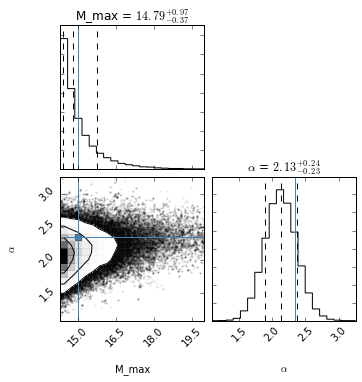

In [46]:
### now for N=100
N = 100
M_min = 3
M_max = 15
alpha = 2.35
sample = power_law_samples(N, M_min, M_max, alpha)

### now let's set up emcee
ndim, nwalkers = 2, 100
pos = [np.array([15, 2.5]) + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[3., sample])
pos1, prob, state = sampler.run_mcmc(pos, 500)
sampler.reset()
sampler.run_mcmc(pos1, 2000, rstate0=state);

samples = sampler.chain[:,:, :].reshape((-1, ndim))
fig4 = corner.corner(samples, labels=["M_max", r"$\alpha$"], quantiles=[0.16, 0.5, 0.84], truths=[15, 2.35],\
                    show_titles=True)
plt.show(fig4)

Both $M_\text{max}$ and $\alpha$ are within 1 $\sigma$.

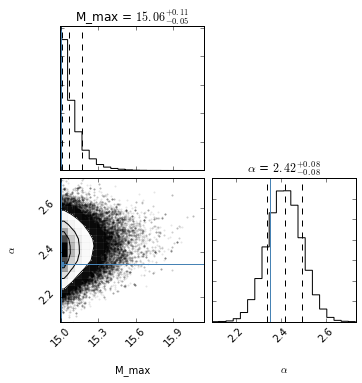

In [47]:
### N=1000
N = 1000
M_min = 3
M_max = 15
alpha = 2.35
sample = power_law_samples(N, M_min, M_max, alpha)

### now let's set up emcee
ndim, nwalkers = 2, 100
pos = [np.array([15, 2.5]) + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[3., sample])
pos1, prob, state = sampler.run_mcmc(pos, 500)
sampler.reset()
sampler.run_mcmc(pos1, 2000, rstate0=state);

samples = sampler.chain[:,:, :].reshape((-1, ndim))
fig4 = corner.corner(samples, labels=["M_max", r"$\alpha$"], quantiles=[0.16, 0.5, 0.84], truths=[15, 2.35],\
                    show_titles=True)
plt.show(fig4)

$M_\text{max}$ is just outside 1 $\sigma$, $\alpha$ is within 1 $\sigma$.

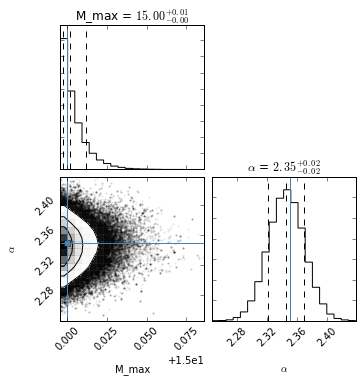

In [49]:
### N=10000
N = 10000
M_min = 3
M_max = 15
alpha = 2.35
sample = power_law_samples(N, M_min, M_max, alpha)

### now let's set up emcee
ndim, nwalkers = 2, 100
pos = [np.array([15, 2.5]) + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[3., sample])
pos1, prob, state = sampler.run_mcmc(pos, 1000)
sampler.reset()
sampler.run_mcmc(pos1, 2000, rstate0=state);

samples = sampler.chain[:,:, :].reshape((-1, ndim))
fig4 = corner.corner(samples, labels=["M_max", r"$\alpha$"], quantiles=[0.16, 0.5, 0.84], truths=[15, 2.35],\
                    show_titles=True)
plt.show(fig4)

Okay, now we're pretty close to the correct values for both $M_\text{max}$ and $\alpha$. Which makes sense, since we have so many samples.

A general trend is that the more samples you have, the better you can constrain the values of your parameters, i.e the 1 $\sigma$ confidence interval gets smaller and smaller.